In [4]:
import numpy as np
import torch as t
import torch.nn.functional as funct
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [5]:
def load_dataset(path:str, squeeze=False):
    with open(path, 'rb') as f:
        d = np.load(f, allow_pickle=True)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        enc_vect = d['enc_dict']
        enc_dict = {i:class_ for class_ ,i in zip(enc_vect, range(enc_vect.shape[0]))}

    if squeeze:
        X_train = np.squeeze(X_train)
        X_test = np.squeeze(X_test)

    return (X_train,y_train,X_test,y_test,enc_dict)

In [6]:
if t.cuda.is_available():
  device = t.device("cuda")
else:
  device = t.device("cpu")

In [7]:
device

device(type='cpu')

In [8]:
X_train_raw, y_train_raw, X_test, y_test, encdict = load_dataset('../dataset_tab/tracks_processed.npz')

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.1, stratify=y_train_raw, random_state=8)

In [10]:
y_train = t.Tensor(y_train).type(t.LongTensor)
y_val = t.Tensor(y_val).type(t.LongTensor).to(device)
y_test = t.Tensor(y_test).type(t.LongTensor)


In [11]:
X_train = t.Tensor(X_train)
X_val = t.Tensor(X_val).to(device)
X_test = t.Tensor(X_test)

In [12]:
X_train.shape, X_val.shape

(torch.Size([52890, 36]), torch.Size([5877, 36]))

In [13]:
data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)


train_dataloader = DataLoader(data_train, batch_size=500, shuffle=True, num_workers=2)
test_dataloader = DataLoader(data_test, batch_size=1, shuffle=True, num_workers=2)

In [14]:
class MLP(t.nn.Module):
  def __init__(self):
    super().__init__()


    # layer denso 1
    self.dense1 = t.nn.Linear(36, 128)

    # layer denso 2
    self.dense2 = t.nn.Linear(128, 256)

    # layer denso 3
    self.dense3 = t.nn.Linear(256, 256)

    #self.dense35 = t.nn.Linear(292, 350)

    # layer denso 4
    #self.dense4 = t.nn.Linear(256, 256)

    # layer di output
    self.out = t.nn.Linear(256,114)

    # dropout
    self.dropout = t.nn.Dropout(p=0.2)

    # batchnorm
    self.batchnorm1 = t.nn.BatchNorm1d(128)
    self.batchnorm2 = t.nn.BatchNorm1d(256)
    self.batchnorm3 = t.nn.BatchNorm1d(256)
    #self.batchnorm4 = t.nn.BatchNorm1d(256)
    #self.batchnorm35 = t.nn.BatchNorm1d(350)


  def forward(self, x):
    
    # primo layer denso
    x = self.dense1(x)
    x = self.batchnorm1(x)
    x = funct.relu(x)
    x = self.dropout(x)

    

    # secondo layer denso
    x = self.dense2(x)
    x = self.batchnorm2(x)
    x = funct.relu(x)
    x = self.dropout(x)

    # terzo layer denso
    x = self.dense3(x)
    x = self.batchnorm3(x)
    x = funct.relu(x)
    x = self.dropout(x)



    # layer di output
    x = self.out(x)
    x = funct.softmax(x)

    return x

In [15]:
model = MLP().to(device)

In [16]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [17]:
import time

In [18]:
# loss function and optimizer
loss = t.nn.CrossEntropyLoss() 
opt = t.optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 200   
batch_size = 500 
batches_per_epoch = X_train.shape[0] // batch_size

 
time_ = time.time()
delta_time = 0

best_acc = 0
patience = 0


for epoch in range(n_epochs):
  model.train()

  running_loss_val = 0.0
  running_acc = 0.0
  for i, data in enumerate(train_dataloader):
    X = data[0].to(device)
    y = data[1].to(device)

    opt.zero_grad()

    #forward
    y_pred = model(X)

    # calcolo training loss
    loss_val = loss(y_pred, y)
    

    # training accuracy

    train_acc = sum(y_pred.argmax(dim=1) == y) / len(y)

    # backprop
    loss_val.backward()

    # optimization
    opt.step()


    # statistiche
    running_loss_val += loss_val.data.item()
    running_acc += train_acc
    
    
  

  #forward su validazione
  model.eval()

  y_pred_val = model(X_val)
  val_loss_val = loss(y_pred_val, y_val)
  val_acc = sum(y_pred_val.argmax(dim=1) == y_val) / len(y_val)


  delta_time = time.time() - time_
  time_ = time.time()
  print(f'epoca: {epoch+1} | t: {round(delta_time, 2)} sec || train_loss: {running_loss_val/(i+1)} | train_acc: {running_acc/(i+1)} || val_loss: {val_loss_val} | val_acc: {val_acc}' )

  train_loss_list.append(running_loss_val/(i+1))
  train_acc_list.append(((running_acc/(i+1)).item()))
  val_loss_list.append(val_loss_val.item())
  val_acc_list.append(val_acc.item())

  

  if val_acc.item() > best_acc:
    best_acc = val_acc.item()
    patience = 0
  else:
    patience += 1
    if patience == 50:
      print('BLOCCATO')
      break


  running_loss_val = 0.0
  running_acc = 0.0

C:\Users\giuli\AppData\Local\Temp\ipykernel_15820\3935245895.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = funct.softmax(x)


epoca: 1 | t: 4.7 sec || train_loss: 4.669298689320402 | train_acc: 0.09491533041000366 || val_loss: 4.6112823486328125 | val_acc: 0.15467074513435364
epoca: 2 | t: 4.64 sec || train_loss: 4.591956723411128 | train_acc: 0.17508083581924438 || val_loss: 4.549161911010742 | val_acc: 0.2167772650718689
epoca: 3 | t: 4.72 sec || train_loss: 4.555164260684319 | train_acc: 0.20947988331317902 || val_loss: 4.529876708984375 | val_acc: 0.2331121265888214
epoca: 4 | t: 4.78 sec || train_loss: 4.540470010829422 | train_acc: 0.2213260680437088 || val_loss: 4.518664360046387 | val_acc: 0.24161987006664276
epoca: 5 | t: 5.04 sec || train_loss: 4.532437153582303 | train_acc: 0.22739282250404358 || val_loss: 4.513850212097168 | val_acc: 0.24485281109809875
epoca: 6 | t: 5.24 sec || train_loss: 4.526369999039848 | train_acc: 0.23248088359832764 || val_loss: 4.510610580444336 | val_acc: 0.2482559084892273
epoca: 7 | t: 5.36 sec || train_loss: 4.521704687262481 | train_acc: 0.2368423044681549 || val_los

In [36]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(model)

66554

### Test

In [37]:
np.unique(y_test, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113]),
 array([267, 294,  86, 154, 252, 216, 290, 294, 177, 234, 289, 170, 261,
        293, 280, 199, 211, 288, 236, 166,  84, 193, 197, 155, 281, 180,
        263, 274, 244,  80,  46,  97, 253, 235, 164, 287, 268, 173, 260,
        192, 233, 267, 297, 250, 265, 271, 277, 196, 235, 272, 297, 198,
        294, 195, 293, 253,  53, 179, 275, 279, 291, 295, 219, 1

In [38]:

def decode_y(y_enc, enc_dict):
    return [enc_dict[y] for y in y_enc]

In [39]:
y_test = [y.item() for y in y_test]

AttributeError: 'int' object has no attribute 'item'

In [42]:
from sklearn.metrics import classification_report


model.eval()

y_pred_test_prob = model(X_test)
y_pred_test = y_pred_test_prob.argmax(dim=1)
y_pred_test = [y.item() for y in y_pred_test]

print(classification_report(decode_y(y_test, encdict), decode_y(y_pred_test, encdict), zero_division=True))

C:\Users\giuli\AppData\Local\Temp\ipykernel_6104\837520654.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = funct.softmax(x)


                   precision    recall  f1-score   support

         acoustic       1.00      0.00      0.00       267
         afrobeat       0.23      0.24      0.24       294
         alt-rock       1.00      0.00      0.00        86
      alternative       1.00      0.00      0.00       154
          ambient       0.27      0.35      0.30       252
            anime       1.00      0.00      0.00       216
      black-metal       0.42      0.53      0.47       290
        bluegrass       0.38      0.51      0.44       294
            blues       1.00      0.00      0.00       177
           brazil       1.00      0.00      0.00       234
        breakbeat       0.28      0.24      0.26       289
          british       1.00      0.00      0.00       170
         cantopop       0.22      0.24      0.23       261
    chicago-house       0.34      0.55      0.42       293
         children       0.36      0.36      0.36       280
            chill       1.00      0.00      0.00       

In [62]:
def top_flop_f1(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    l = [(key, val['f1-score']) for key,val in report.items() if (isinstance(val, dict) and key not in ['macro avg', 'weighted avg'])]
    l.sort(key= lambda x: x[1], reverse=True)
    top5 = l[:5]
    l.sort(key= lambda x: x[1], reverse=False)
    flop5 = l[:5]

    print('TOP 5 F1-SCORE:')
    for top in top5:
        print(f'{top[0]}: {top[1]}')

    print('\n\nFLOP 5 F1-SCORE:')
    for flop in flop5:
        print(f'{flop[0]}: {flop[1]}')

top_flop_f1(decode_y(y_test, encdict), decode_y(y_pred_test, encdict))

TOP 5 F1-SCORE:
comedy: 0.7948164146868251
grindcore: 0.7414050822122571
sleep: 0.7386091127098321
honky-tonk: 0.6507462686567164
study: 0.6378504672897196


FLOP 5 F1-SCORE:
alt-rock: 0.0
alternative: 0.0
anime: 0.0
blues: 0.0
brazil: 0.0


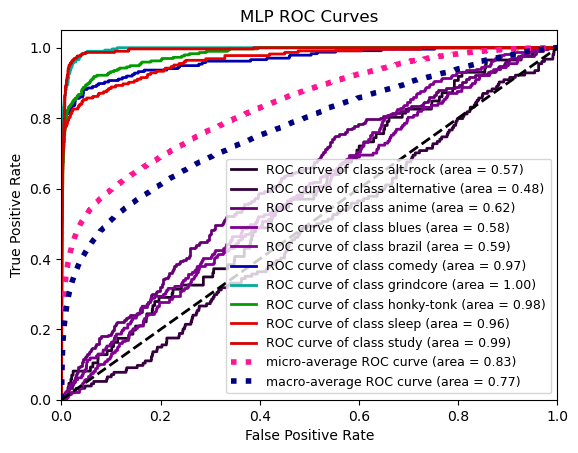

In [68]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

plot_roc(decode_y(y_test, encdict), y_pred_test_prob.detach().numpy(), classes_to_plot=['comedy', 'grindcore', 'sleep', 'honky-tonk', 'study', 
                                                                                        'alt-rock', 'alternative', 'anime', 'blues', 'brazil'])
plt.legend(loc='lower right',prop={'size': 9})
plt.title('MLP ROC Curves')
plt.show()

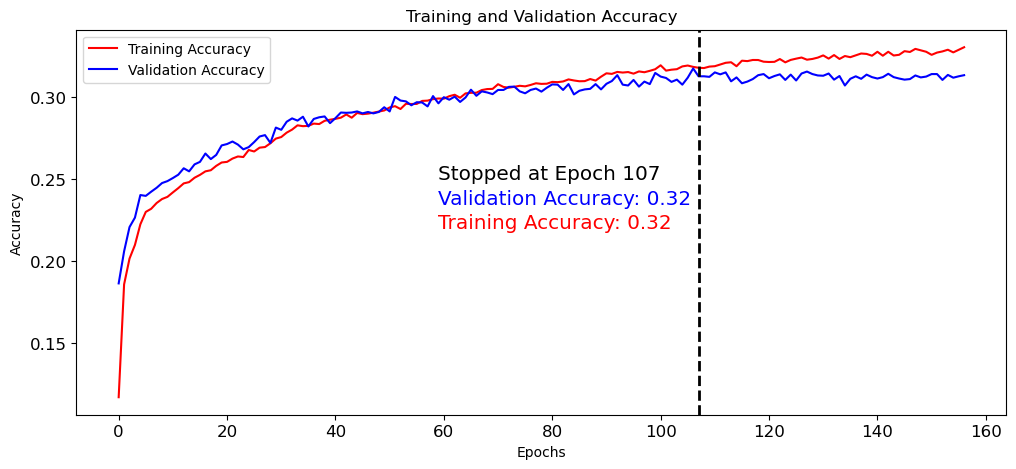

In [100]:
epochs = range(len(train_acc_list))

plt.figure(figsize=(12,5))
plt.plot(epochs, train_acc_list, label='Training Accuracy', c='red')
plt.plot(epochs, val_acc_list, label='Validation Accuracy', c='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x=np.argmax(val_acc_list)+1, c='black', linestyle='--', linewidth=2)
plt.text(x=np.argmax(val_acc_list)-47, y=0.25, s=f'Stopped at Epoch {np.argmax(val_acc_list)+1}', fontsize='x-large')
plt.text(x=np.argmax(val_acc_list)-47, y=0.235, s=f'Validation Accuracy: {round(val_acc_list[np.argmax(val_acc_list)], 2)}', c='blue', fontsize='x-large')
plt.text(x=np.argmax(val_acc_list)-47, y=0.22, s=f'Training Accuracy: {round(train_acc_list[np.argmax(val_acc_list)], 2)}', c='red', fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.show()

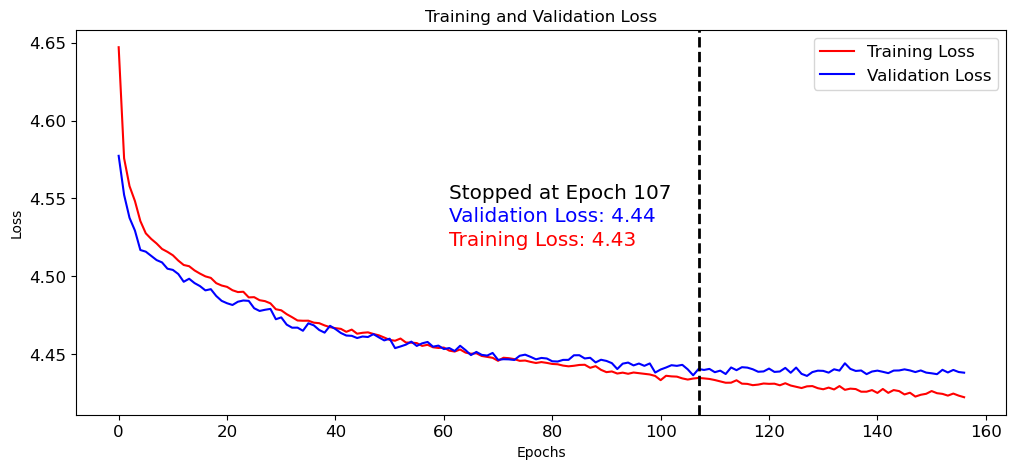

In [102]:
plt.figure(figsize=(12,5))
plt.plot(epochs, train_loss_list, label='Training Loss', c='red')
plt.plot(epochs, val_loss_list, label='Validation Loss', c='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize='large')
plt.axvline(x=np.argmax(val_acc_list)+1, c='black', linestyle='--', linewidth=2)
plt.text(x=np.argmax(val_acc_list)-45, y=4.55, s=f'Stopped at Epoch {np.argmax(val_acc_list)+1}', fontsize='x-large')
plt.text(x=np.argmax(val_acc_list)-45, y=4.535, s=f'Validation Loss: {round(val_loss_list[np.argmax(val_acc_list)], 2)}', c='blue', fontsize='x-large')
plt.text(x=np.argmax(val_acc_list)-45, y=4.52, s=f'Training Loss: {round(train_loss_list[np.argmax(val_acc_list)], 2)}', c='red', fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.show()